# Notebook TFM
<div style="background-color:#F2EDED;">
<br/>
<div>
<img src="https://uploads-ssl.webflow.com/614b1fe22fa8b90ef41aeffe/6265cb48f9496b1cefc9ab75_logotipo-mbit-39.png" width="200px" align="left" CLASS="TextWrap" style="background-color:#2a3f3f; margin-left: 10px;">
<img src="https://branding-guidelines.msf.es/esp/imgs/logo/Logo-01.jpg" width="100px" align="right" CLASS="TextWrap" style="background-color:#2a3f3f;">
</div>
<br/>
<br/>
<br/>
<div>
<h1><font color="#2a3f3f" size=4 style="margin-left: 10px;">MODELO DE PROBABILIDAD A TESTAR EN MÉDICOS SIN FRONTERAS</font></h1>
</div>
<br/>
<div style="text-align: right; margin-right: 10px; margin-bottom: 10px;">
<font color="#2a3f3f" size=3>Elio López Salamanca </font><br>
<font color="#2a3f3f" size=3>Sergio Israel Calleja Chimeno</font><br>
</div>
</div>

En este proyecto vamos a generar un caso de uso que ayude a MSF a detectar socios potenciales que puedan
dejar el testamento a favor de MSF.

En este notebook vamos a hacer el preprocesamiento necesario para poder entrenar y evaluar un modelo
que prediga si el socio potencialmente puede dejar dicho testamento a favor

Este notebook consiste en los siguientes pasos

1. **Lectura de datos**: lectura de la BBDD carga en Athena
2. **Exploratorio y limpieza de datos**: hacemos un exploratorio y limpieza de datos
3. **Analisis en profundidad de datos**: analizamos en profundidad la información
4. **Generación dataset entrenamiento**: dejamos un dataset listo para entrenar/evaluar nuestro modelo

## Imports e instalables necesarios

In [2]:
%%capture --no-display
import sys
!{sys.executable} -m pip install awswrangler;

In [3]:
import awswrangler as wr
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from types import NoneType
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Leemos los datos de Athena
- Para ello nos apoyamos en la libreria awswrangler, que nos permite leer los datos de Athena, de una manera eficiente en memoria
- Agrupamos todos los campos categóricos en listas, para facilitar el traslado a columnas, de una manera más eficiente que el uso de get_dummies

In [4]:
%%time

path = 's3://enriched-msf-mbit/ContactsOpportunitiesAgg/'

df_model_athena = wr.athena.read_sql_query('''select 
array_agg(distinct opp_rating) as opp_rating,
array_agg(distinct opp_stagename) as opp_stagename,
array_agg(distinct opp_program) as opp_program,
array_agg(distinct opp_typefundraisingcontribution) as opp_typefundraisingcontribution,
cnt_id, 
max(cnt_ltvscore ) as cnt_ltvscore ,
array_agg(distinct cnt_program) as cnt_program ,
max(cnt_programaherencias ) as cnt_programaherencias ,
max(cnt_programais) as cnt_programais,
max(cnt_legacyconfidentiality ) as cnt_legacyconfidentiality ,
array_agg(distinct cnt_membertype ) as cnt_membertype ,
array_agg(distinct cmp_campaigndonationreporting ) as cmp_campaigndonationreporting ,
array_agg(distinct cmp_campaignentryreporting) as cmp_campaignentryreporting,
max(cmp_isemergency ) as cmp_isemergency ,
array_agg(distinct cmp_isonline ) as cmp_isonline ,
array_agg(distinct cmp_objective ) as cmp_objective ,
array_agg(distinct cmp_objectivepublic ) as cmp_objectivepublic ,
array_agg(distinct cmp_segment ) as cmp_segment ,
array_agg(distinct cmp_status) as cmp_status,
max(rcd_isdeleted ) as rcd_isdeleted ,
max(rcd_annualizedquota ) as rcd_annualizedquota ,
max(rcd_amount ) as rcd_amount ,
max(rcd_paidamount) as rcd_paidamount,
max(rcd_totalpaidinstallments) as rcd_totalpaidinstallments,
array_agg(distinct rcd_installmentperiod) as rcd_installmentperiod,
array_agg(distinct opp_type) as opp_type
FROM msfdb_enrich.enrich_contactsopportunitiesagg
group by cnt_id''', database="msfdb_enrich")

df_model_athena.head(8)

CPU times: user 4.49 s, sys: 978 ms, total: 5.46 s
Wall time: 14.9 s


,opp_rating,opp_stagename,opp_program,opp_typefundraisingcontribution,cnt_id,cnt_ltvscore,cnt_program,cnt_programaherencias,cnt_programais,cnt_legacyconfidentiality,...,cmp_objectivepublic,cmp_segment,cmp_status,rcd_isdeleted,rcd_annualizedquota,rcd_amount,rcd_paidamount,rcd_totalpaidinstallments,rcd_installmentperiod,opp_type
0,"[Caliente, ]","[Cobrada, Puesta al cobro]","[, Cultivacion socios MASS]",[S],0033Y00002uphFXQAY,8.0,[Cultivacion socios MASS],False,False,False,...,[],[Mass donors],[Completed],False,300.0,300.0,1200.0,5.0,[Yearly],[Recurrent Donation]
1,"[Caliente, ]","[Cobrada, Puesta al cobro]","[Cultivacion socios MASS, ]",[S],0033Y00002uNmm0QAC,7.0,[Cultivacion socios MASS],False,False,False,...,[],[Frio individuos],[Completed],False,120.0,10.0,670.0,67.0,[Monthly],[Recurrent Donation]
2,[Caliente],"[Cobrada, Puesta al cobro]","[Retencion 1r ano MASS, Cultivacion socios MAS...",[S],0033Y00003S4BQWQA3,2.0,[Cultivacion socios MASS],False,False,False,...,[],[Mass donors],[Created],False,72.0,6.0,78.0,13.0,[Monthly],[Recurrent Donation]
3,[],"[Cobrada, Impagada]",[],[S],0033Y00002upLF4QAM,2.0,[Reactivacion bajas MASS],False,False,False,...,[],[Frio individuos],[Completed],False,30.0,30.0,60.0,2.0,[Yearly],[Recurrent Donation]
4,"[, Caliente]","[Cobrada, Puesta al cobro]","[, Cultivacion socios MASS]",[S],0033Y00002up3VFQAY,7.0,[Cultivacion socios MASS],False,False,False,...,[],[Frio individuos],[Completed],False,180.0,15.0,1005.0,67.0,[Monthly],[Recurrent Donation]
5,"[, Caliente]","[Cobrada, Puesta al cobro]","[, Cultivacion socios MASS]",[S],0033Y00002upsjcQAA,8.0,[Cultivacion socios MASS],False,False,False,...,[],[Frio individuos],[Completed],False,360.0,30.0,1722.0,67.0,[Monthly],[Recurrent Donation]
6,"[Caliente, ]","[Cobrada, Puesta al cobro]","[Retencion 1r ano MASS, Cultivacion socios MAS...",[S],0033Y00002uq3jlQAA,6.0,[Cultivacion socios MASS],False,False,False,...,[],[Leads],[Completed],False,204.0,17.0,714.0,42.0,[Monthly],[Recurrent Donation]
7,"[Caliente, ]","[Cobrada, Puesta al cobro]","[, Cultivacion socios MASS]",[S],0033Y00002unbTCQAY,7.0,[Cultivacion socios MASS],False,True,False,...,[],[Frio individuos],[Completed],False,180.0,15.0,1005.0,67.0,[Monthly],[Recurrent Donation]


## Exploratorio de datos
- Vemos los tipos de columna
- Vemos volumetrias

In [5]:
df_model_athena.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687224 entries, 0 to 687223
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   opp_rating                       687224 non-null  object 
 1   opp_stagename                    687224 non-null  object 
 2   opp_program                      687224 non-null  object 
 3   opp_typefundraisingcontribution  687224 non-null  object 
 4   cnt_id                           687224 non-null  string 
 5   cnt_ltvscore                     687224 non-null  float64
 6   cnt_program                      687224 non-null  object 
 7   cnt_programaherencias            687224 non-null  boolean
 8   cnt_programais                   687224 non-null  boolean
 9   cnt_legacyconfidentiality        687224 non-null  boolean
 10  cnt_membertype                   687224 non-null  object 
 11  cmp_campaigndonationreporting    687224 non-null  object 
 12  cm

In [6]:
df_model_athena.shape

(687224, 26)

## Transformaciones de datos

### Paso 1
- Recorremos el dataset, generando una columna por cada valor de los campos tipo lista, antes eliminamos de la lista valores vacios
- Utilizamos la libreria MultiLabelBinarizer que por cada campo de tipo lista, devuelve una columna con valores 1, 0 en función de si está o no

In [7]:
df_model_athena.set_index('cnt_id');

In [8]:
df_model_athena_dummys = df_model_athena
def gene_list(x, column):
    list_dat = []
    for val in x:
        if val and val != '':
            list_dat.append(column + "_" + val)
    return list_dat
for col, typ in zip(df_model_athena_dummys.columns, df_model_athena_dummys.dtypes):
    if typ == 'object':
        df_model_athena_dummys[col] = df_model_athena_dummys[col].apply(gene_list, column=col)
        mlb = MultiLabelBinarizer()
        a = mlb.fit_transform(df_model_athena_dummys[col])
        df_expanded = pd.DataFrame(a, columns=mlb.classes_, index=df_model_athena_dummys.index)
        # merge them using the following:
        df_model_athena_dummys = df_model_athena_dummys.merge(df_expanded, left_index=True, right_index=True)

### Paso 2
Eliminamos las columnas de tipo lista

In [9]:
for col, typ in zip(df_model_athena_dummys.columns, df_model_athena_dummys.dtypes):
    if typ == 'object':
        df_model_athena_dummys = df_model_athena_dummys.drop([col],axis=1)

In [10]:
df_model_athena_dummys.shape

(687224, 171)

### Paso 3
- Buscamos outliers en los datos, es decir valores anómalos y los reemplazamos por los valores más altos o bajos

In [11]:
for col, typ in zip(df_model_athena_dummys.columns, df_model_athena_dummys.dtypes):
    if typ != "string" and typ != "int64" and typ != "boolean":
        upper_limit = df_model_athena_dummys[col].mean() + 3* df_model_athena_dummys[col].std() # Right from the mean
        lower_limit = df_model_athena_dummys[col].mean() - 3* df_model_athena_dummys[col].std() # Left from the mean
        df_model_athena_dummys[col].loc[(df_model_athena_dummys[col] > upper_limit)] = upper_limit
        df_model_athena_dummys[col].loc[(df_model_athena_dummys[col] < lower_limit)] = lower_limit
    

/tmp/ipykernel_880/2493348499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_athena_dummys[col].loc[(df_model_athena_dummys[col] > upper_limit)] = upper_limit
/tmp/ipykernel_880/2493348499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_athena_dummys[col].loc[(df_model_athena_dummys[col] < lower_limit)] = lower_limit


In [12]:
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_columns', None)
df_model_athena_dummys.sort_values(by="rcd_totalpaidinstallments", ascending=False).head(10)

/tmp/ipykernel_880/848794032.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,cnt_id,cnt_ltvscore,cnt_programaherencias,cnt_programais,cnt_legacyconfidentiality,cmp_isemergency,rcd_isdeleted,rcd_annualizedquota,rcd_amount,rcd_paidamount,rcd_totalpaidinstallments,opp_rating_Caliente,opp_rating_Frio,opp_rating_Templado,opp_stagename_Cancelada,opp_stagename_Cobrada,opp_stagename_Devuelta,opp_stagename_Devuelta manual,opp_stagename_Impagada,opp_stagename_Interesado proactivo (espontaneo),opp_stagename_Interesado reactivo (prompted),opp_stagename_Muy interesado,opp_stagename_No insistir: Elaborando testamento,opp_stagename_No interesado (no interes o error),opp_stagename_Perdida Cambio testamento (vivo),opp_stagename_Perdida Interesado (fallecido),opp_stagename_Perdida Interesado (vivo),opp_stagename_Puesta al cobro,opp_stagename_Testamento a favor,opp_program_Conversion prospectos,opp_program_Cultivacion socios MASS,opp_program_Cultivacion socios MID,opp_program_Cultivacion/conversion Donantes MASS,opp_program_Cultivacion/conversion Donantes MID,opp_program_Empresas y Colectivos Estrategicas,opp_program_Empresas y Colectivos Mass,"opp_program_Empresas y Colectivos Mid, Mid +",opp_program_Fundaciones Mass,"opp_program_Fundaciones Mid, Mid +",opp_program_Instituciones Publicas Mass,opp_program_Major Donors,opp_program_Mid+ Donors,opp_program_Otros 121,opp_program_Otros 12Few+,opp_program_Otros programas transversales,opp_program_Potenciales a Major Donors,opp_program_Prospectos Empresas & Colectivos Mass,opp_program_Publicos Especiales,opp_program_Reactivacion bajas MASS,opp_program_Reactivacion bajas MID,opp_program_Reactivacion/conversion EXDonantes MASS,opp_program_Reactivacion/conversion EXDonantes MID,opp_program_Retencion 1r ano MASS,opp_program_Retencion 1r ano MID,opp_program_Testamentarios,opp_typefundraisingcontribution_A,opp_typefundraisingcontribution_H,opp_typefundraisingcontribution_S,cnt_program_Conversion prospectos,cnt_program_Cultivacion socios MASS,cnt_program_Cultivacion socios MID,cnt_program_Cultivacion/conversion Donantes MASS,cnt_program_Cultivacion/conversion Donantes MID,cnt_program_Empresas y Colectivos Estrategicas,cnt_program_Empresas y Colectivos Mass,"cnt_program_Empresas y Colectivos Mid, Mid +",cnt_program_Fundaciones Mass,"cnt_program_Fundaciones Mid, Mid +",cnt_program_Instituciones Publicas Mass,cnt_program_Major Donors,cnt_program_Mid+ Donors,cnt_program_Otros 12Few+,cnt_program_Otros programas transversales,cnt_program_Potenciales a Major Donors,cnt_program_Prospectos Empresas & Colectivos Mass,cnt_program_Publicos Especiales,cnt_program_Reactivacion bajas MASS,cnt_program_Reactivacion bajas MID,cnt_program_Reactivacion/conversion EXDonantes MASS,cnt_program_Reactivacion/conversion EXDonantes MID,cnt_program_Retencion 1r ano MASS,cnt_program_Retencion 1r ano MID,cnt_program_Testamentarios,cnt_program_Vehiculo donacion de Gran Donante = YES,cnt_membertype_Baja,cnt_membertype_Baja + Donante,cnt_membertype_Baja + Exdonante,cnt_membertype_Donante,cnt_membertype_Exdonante,cnt_membertype_Nada,cnt_membertype_Nada (Donante SMS),cnt_membertype_Socio,cnt_membertype_Socio + Donante,cnt_membertype_Socio + Exdonante,cmp_campaigndonationreporting_11-Tlmk captacion,cmp_campaigndonationreporting_12-Iniciativa Solidaria off line,cmp_campaigndonationreporting_13-Iniciativa Solidaria Online,cmp_campaigndonationreporting_14-Celebraciones,cmp_campaigndonationreporting_15-Television,cmp_campaigndonationreporting_16-Captacion off resto,cmp_campaigndonationreporting_21-Digital leads (email/tlmk),cmp_campaigndonationreporting_22-Digital Publi,cmp_campaigndonationreporting_23-Digital Organico,cmp_campaigndonationreporting_31-Telemarketing fide,cmp_campaigndonationreporting_32-Mailing fide,cmp_campaigndonationreporting_33-Emailing fide,cmp_campaigndonationreporting_34-Officers Mid plus,cmp_campaigndonationreporting_35-Tlmk Mid,cmp_campaigndonationreporting_36-Fide resto,cmp_campaigndonationreporting_41-Officers Grandes empresas,cmp_campaigndonationreporting_42-Officers Grandes donantes,cmp_campaig

### Paso 4
Comprobamos nulos y los eliminamos, poniendo a 0 ya que todo son importes o clase mayoritaria

In [13]:
list_null_columns = df_model_athena_dummys.columns[df_model_athena_dummys.isna().any()].tolist()
for null_col in list_null_columns:
    if df_model_athena_dummys[null_col].dtype == "boolean":
        df_model_athena_dummys[null_col].fillna(False,inplace=True)
    else:
        df_model_athena_dummys[null_col] = df_model_athena_dummys[null_col].apply(lambda x: 0 if np.isnan(x) else x)

In [14]:
df_model_athena_dummys.columns[df_model_athena_dummys.isna().any()].tolist()

[]

## Analisis de datos
Buscamos relaciones entre las variables

### Paso 1
Generamos matriz de correlaciones

In [15]:
correlation_matrix = df_model_athena_dummys.drop(["cnt_id"],axis=1).corr()

In [16]:
cor_pr_her = pd.DataFrame(correlation_matrix["cnt_programaherencias"])

In [17]:
cor_pr_her.sort_values(by="cnt_programaherencias", ascending=False)

,cnt_programaherencias
cnt_programaherencias,1.000000
opp_type_Herencia,0.839126
opp_typefundraisingcontribution_H,0.839017
cmp_campaigndonationreporting_36-Fide resto,0.517187
cmp_campaignentryreporting_34-Fide resto,0.513012
...,...
rcd_installmentperiod_Monthly,-0.063267
opp_stagename_Cobrada,-0.063714
opp_typefundraisingcontribution_S,-0.352938
opp_type_Recurrent Donation,-0.352938


### Paso 2
Nos quedamos con las relaciones con la columna programa herencias

In [18]:
df_agg_prog_her = df_model_athena_dummys.groupby("cnt_programaherencias").agg("sum").select_dtypes("int").T

In [19]:
df_agg_prog_her.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, cnt_programais to opp_type_Recurrent Donation
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   False   164 non-null    object
 1   True    164 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB


### Paso 3
Calculamos totales de las variables objetivo

In [20]:
dat = pd.DataFrame(df_model_athena_dummys.groupby("cnt_programaherencias").count()["cnt_id"]).T

### Paso 4
Cruzamos los datos de la matriz de correlaciones con las distribuciones de socios por variable

In [21]:
df_concat_prog_her = pd.concat([df_agg_prog_her, cor_pr_her], axis=1)

In [22]:
df_concat_prog_her = df_concat_prog_her.loc[df_concat_prog_her[False] != 0]

In [23]:
df_concat_prog_her["dist_col_False"] = df_concat_prog_her[False] / dat[False][0]
df_concat_prog_her["dist_col_True"] = df_concat_prog_her[True] / dat[True][0]
df_concat_prog_her["lift"] = ((df_concat_prog_her["dist_col_True"] - df_concat_prog_her["dist_col_False"]) / (df_concat_prog_her["dist_col_False"]))

### Paso 5
Analizamos diferentes distribuciones por variable

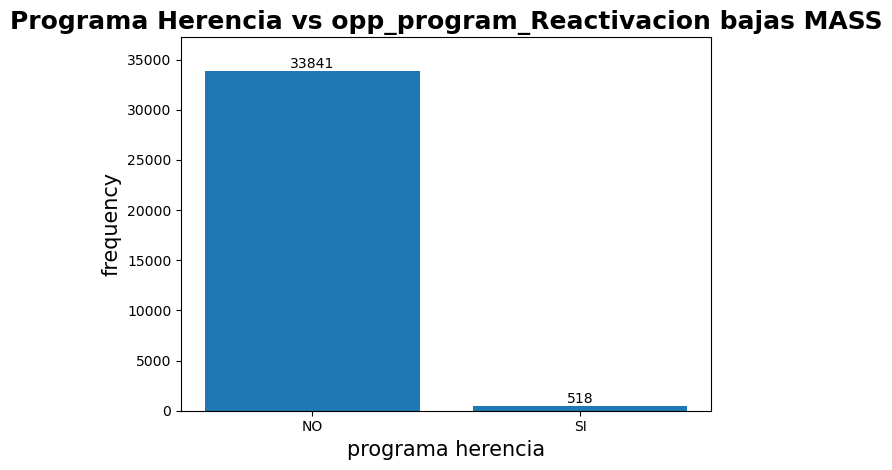

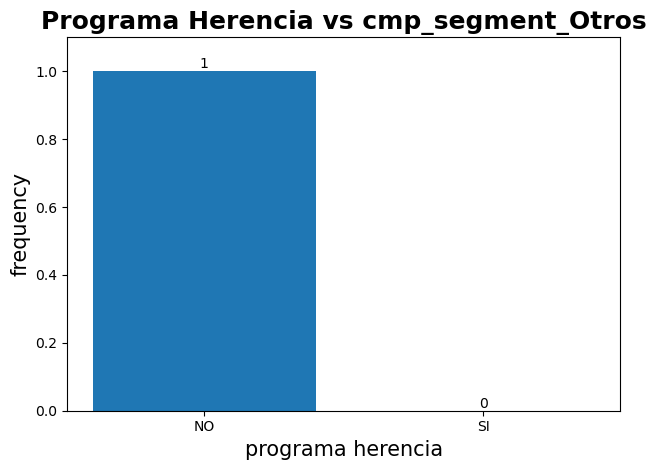

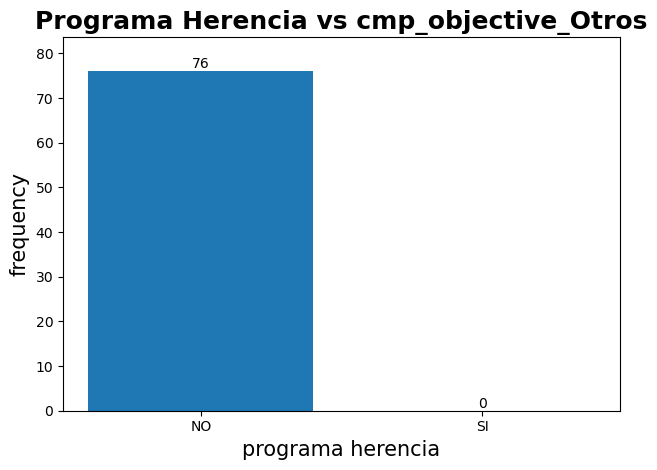

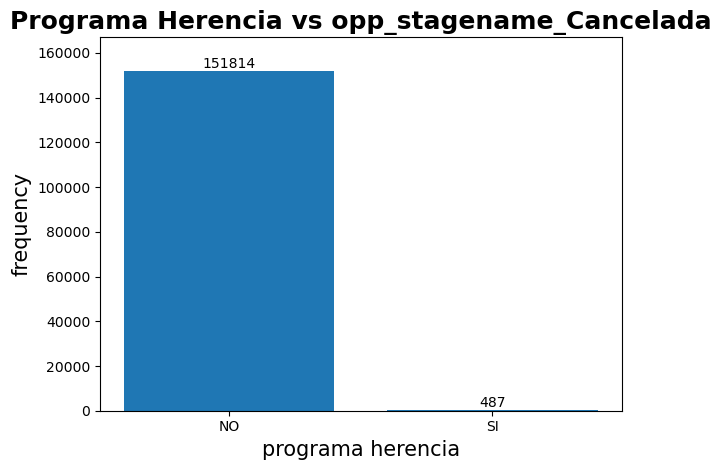

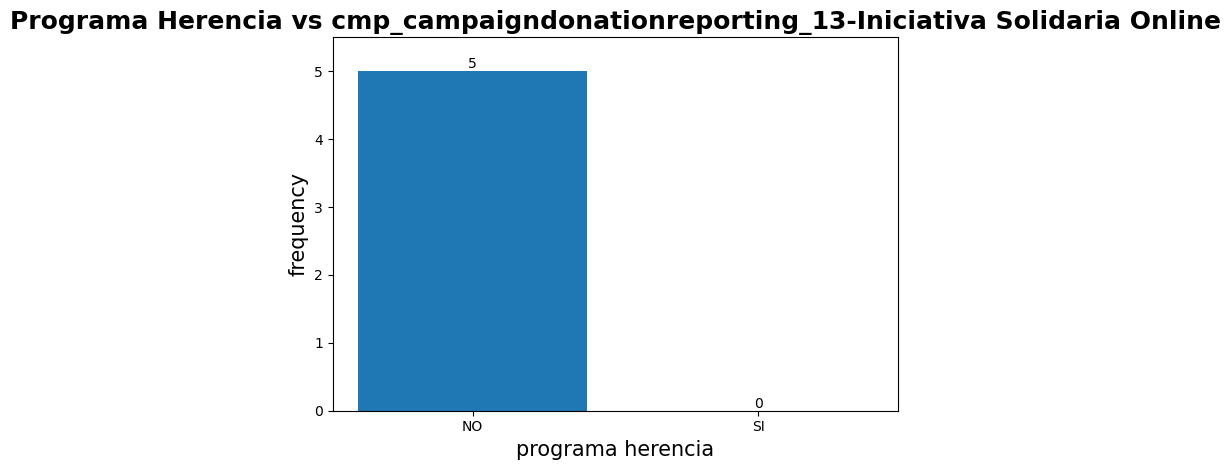

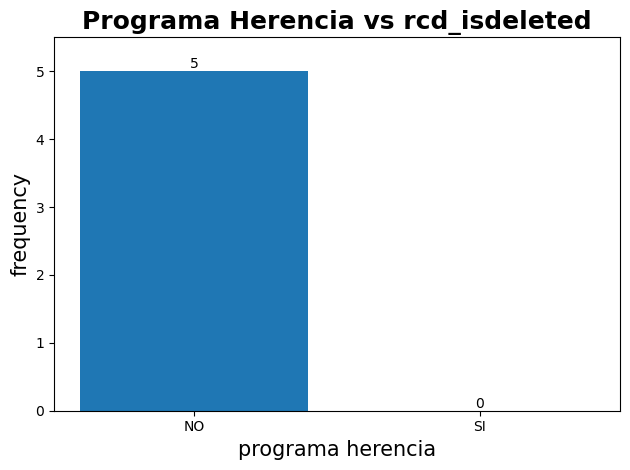

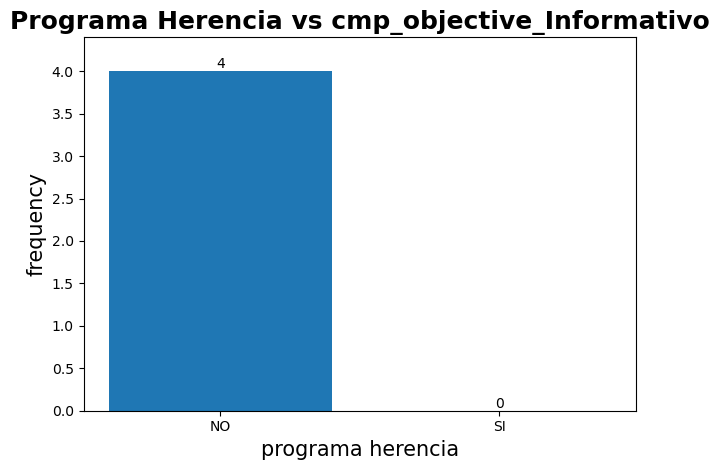

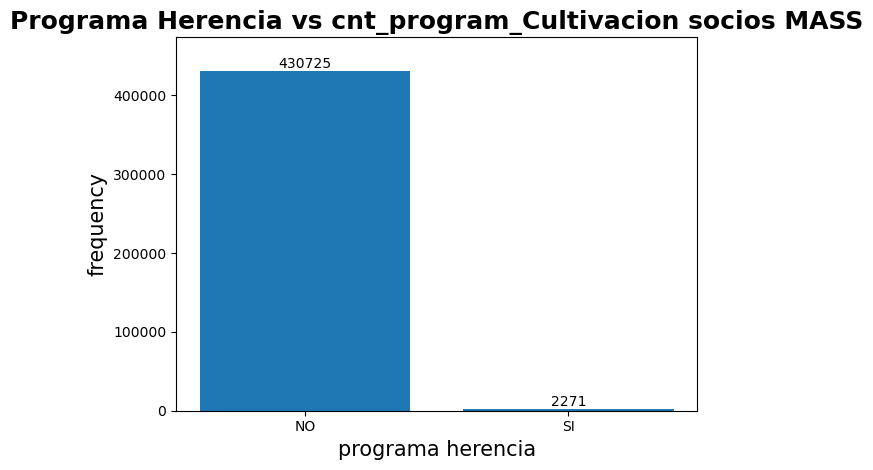

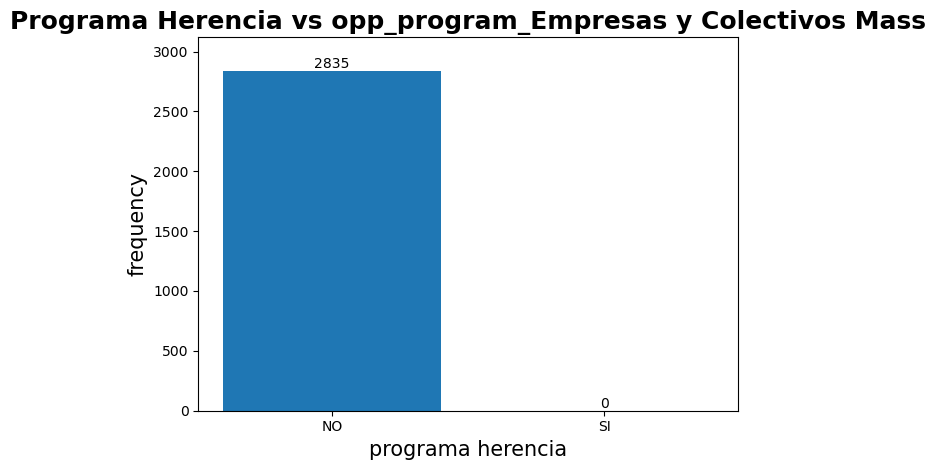

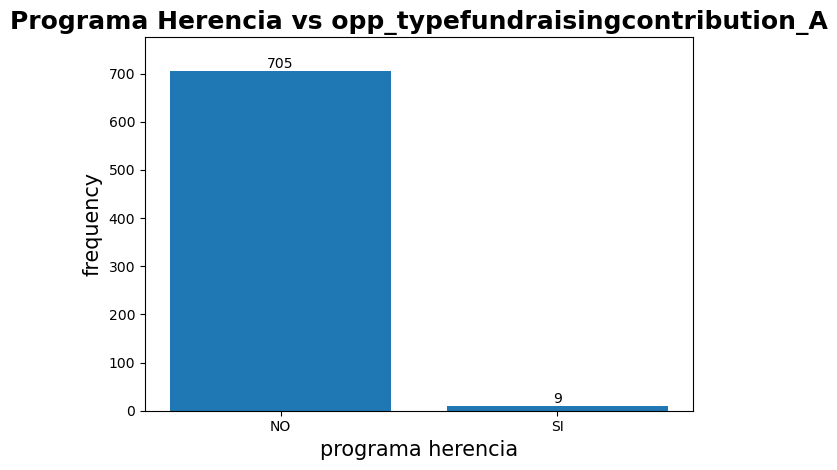

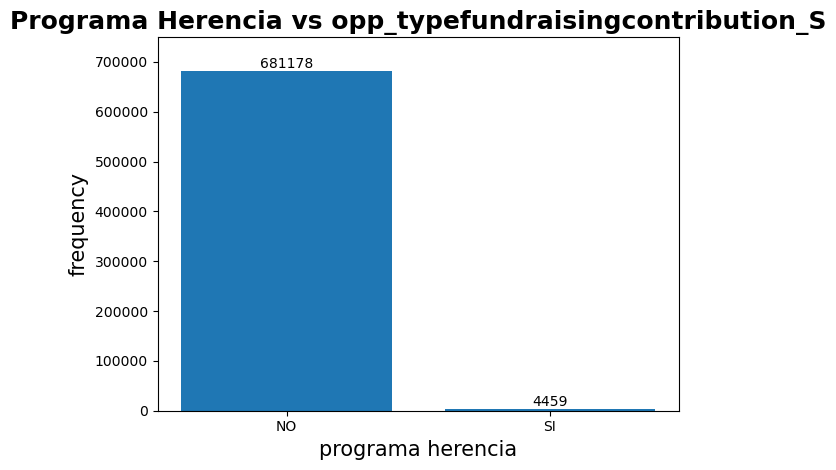

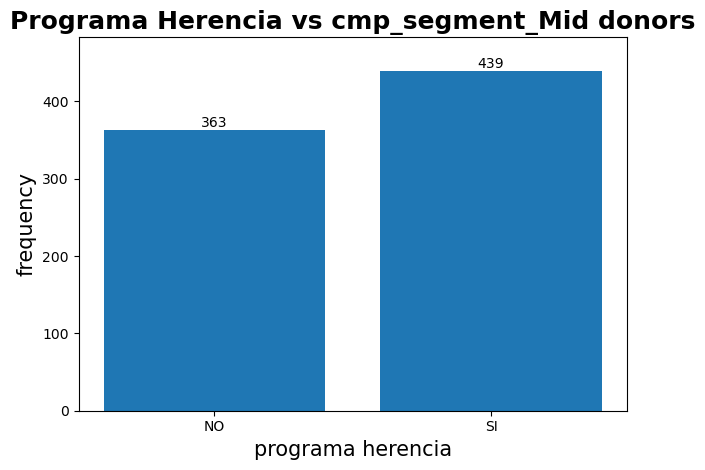

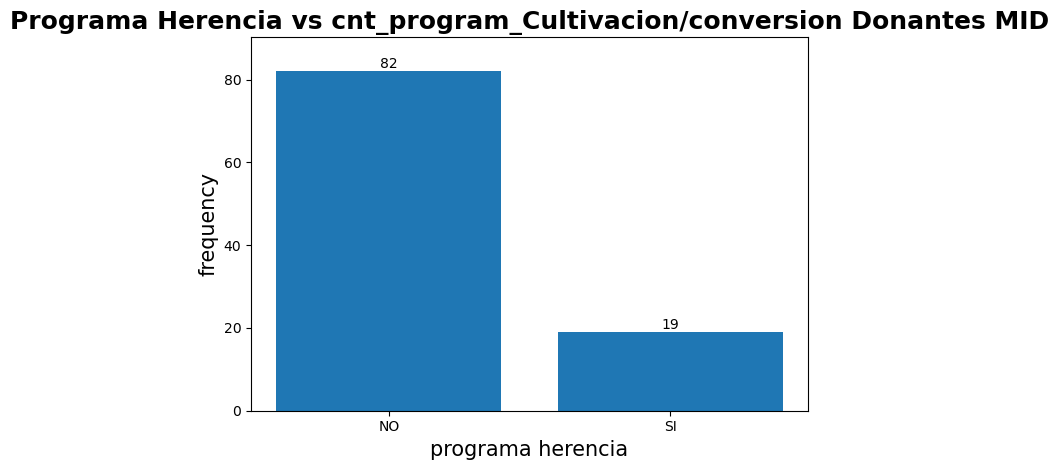

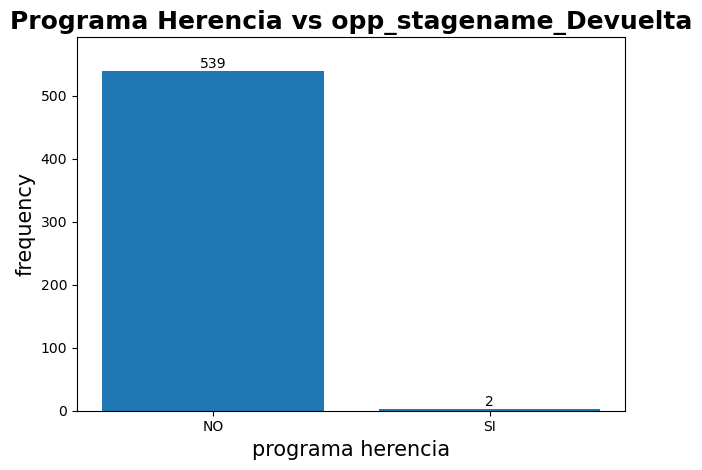

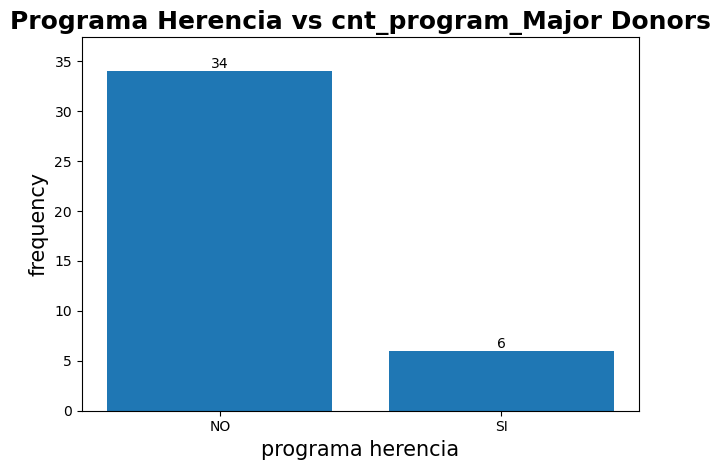

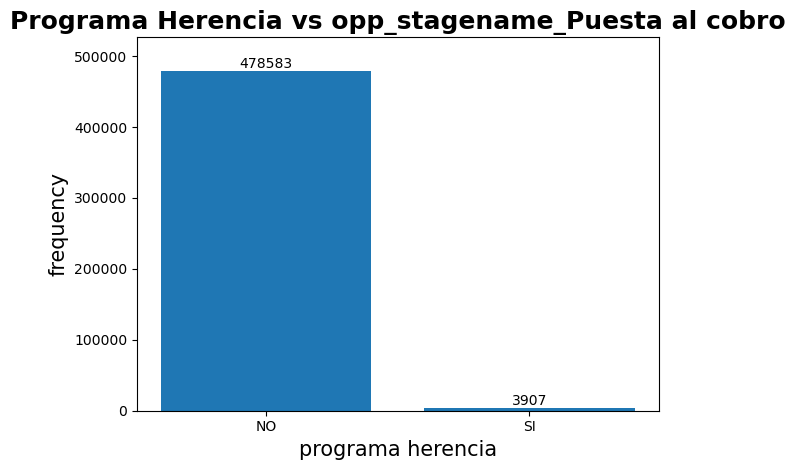

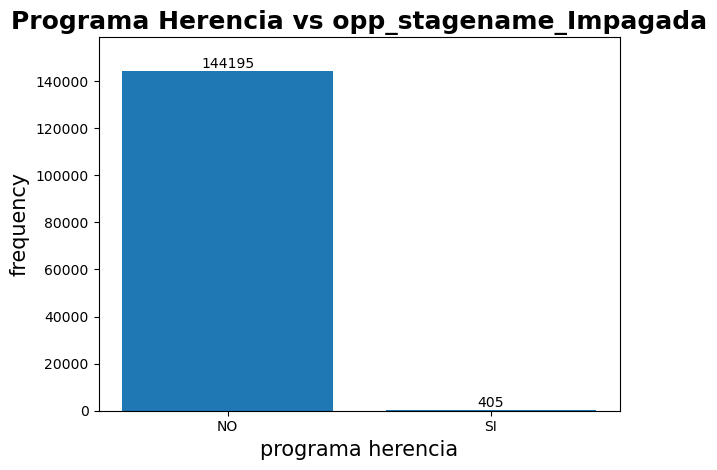

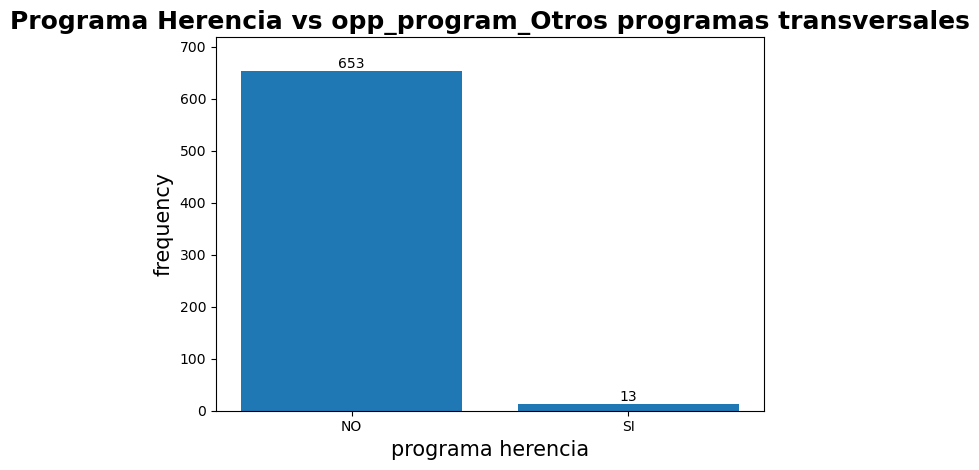

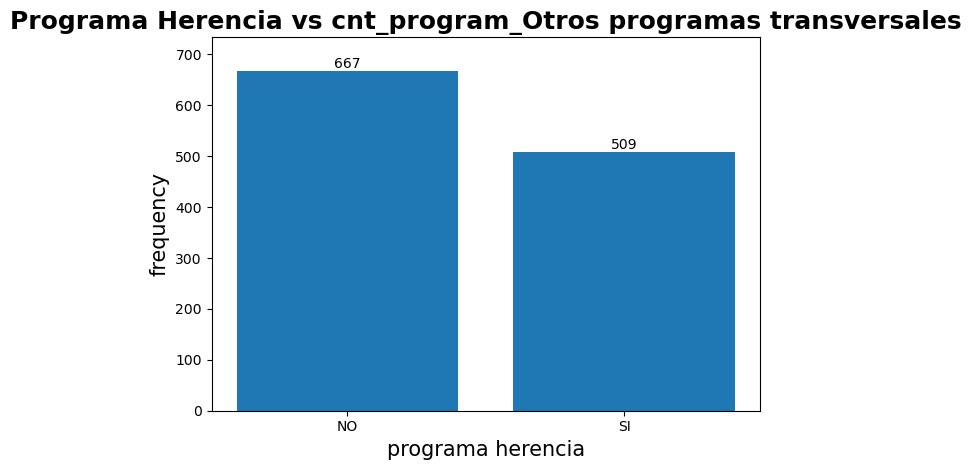

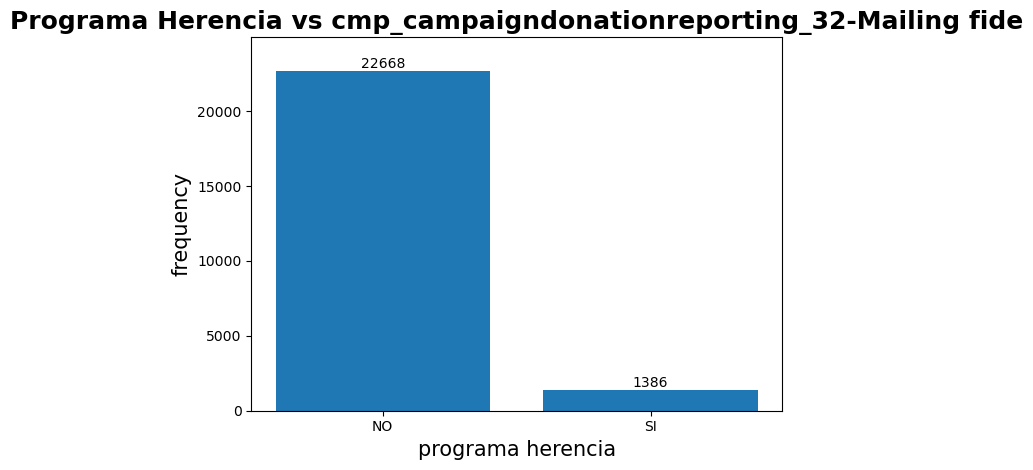

In [24]:
x_values = ("NO", "SI")
list_rows_bars = cor_pr_her.sort_values(by="cnt_programaherencias", ascending=False).sample(20).index
for row in list_rows_bars:
    try:
        df_rel = df_concat_prog_her[[0,1]].loc[row]
    except:
        pass
    p = plt.bar(x_values, df_rel)
    plt.title(f"Programa Herencia vs {row}", fontsize=18, fontweight='bold')
    plt.xlabel('programa herencia', fontsize=15,)
    plt.bar_label(p, label_type='edge')
    plt.ylabel('frequency', fontsize=15)
    plt.margins(y=0.1)
    
    plt.tight_layout()
    plt.show()

### Paso 6
Nos quedamos con las columnas que sigan la siguiente distribución:
- No tener un lift mayor que 10 (es decir que haya 10 veces mas distribución de la variable objetivo tiene programa herencias)
- No tener un lift inferior al 50% del caso opuesta (evitamos variables que no indiquen nada para la variable tiene programa herencias)

In [25]:
variables_salida = df_concat_prog_her.loc[(df_concat_prog_her["lift"]<1000) & (df_concat_prog_her["lift"]>-0.5)]

In [26]:
variables_salida_list = variables_salida.index.tolist() + ["cnt_id"] + ["cnt_programaherencias"]

In [27]:
len(variables_salida_list)

97

## Guardamos la salida en un fichero parquet

In [28]:
df_preprocessed = df_model_athena_dummys[variables_salida_list]

In [29]:
df_preprocessed.to_parquet("msf_df_preprocessed.parquet")